## Train a graph GP model


This notebook provide a simple example to train a graph GP model using a GRF-Diffsuion model.

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import networkx as nx
import numpy as np
from tqdm import tqdm
import torch
from scipy.linalg import expm
from matplotlib import pyplot as plt
import gpytorch


from grf_gp.utils.spectral import get_normalized_laplacian
from grf_gp.utils.sampling import generate_noisy_samples
from grf_gp.utils.visual import plot_gp_with_subsamples
from grf_gp.kernels.diffusion import GRFDiffusionKernel
from grf_gp.model import GraphGP
from grf_gp.sampler import GRFSampler

### Synthetic dataset (2D regular mesh)

In [21]:
mesh_size = 10
num_nodes = mesh_size**2
adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()

In [22]:
beta_sample = 5
noise_std = 0.1
kernel_variance = 10.0

In [23]:
def diffusion_kernel(adj_matrix, beta=2):
    """
    Compute the diffusion kernel matrix for a graph.
    """
    laplacian = get_normalized_laplacian(adj_matrix)
    # laplacian = np.diag(np.sum(adj_matrix, axis=1)) - adj_matrix 
    return expm(-beta * laplacian)  # Matrix exponential


In [37]:
K_true = kernel_variance * diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=0)
Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std, seed=0)
Y_noisy = torch.tensor(Y_noisy, dtype=torch.float32).flatten()
X = torch.arange(num_nodes, dtype=torch.float32)

subsample_factor = 2
torch.manual_seed(42)
train_idx = np.random.choice(num_nodes, num_nodes//subsample_factor, replace=False)
test_idx = np.setdiff1d(np.arange(num_nodes), train_idx)

x_train = X[train_idx]
y_train = Y_noisy[train_idx]
x_test = X[test_idx]
y_test = Y_noisy[test_idx]

/var/folders/0v/vn4885796ql7_mlpq_dc1n9r0000gn/T/ipykernel_48332/3351494523.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Y_subsampled = np.array(Y_subsampled)


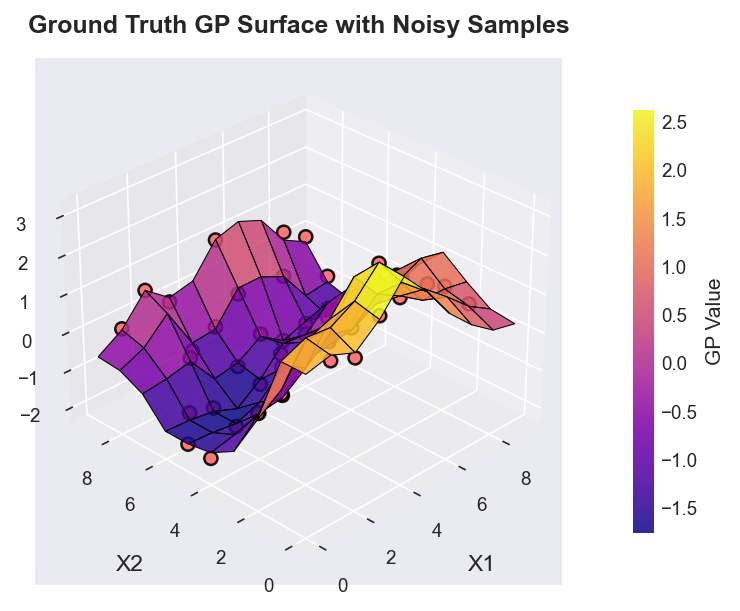

In [38]:
# Plot the GP surface with overlaid subsampled data
plot_gp_with_subsamples(Y, mesh_size, train_idx, Y_noisy[train_idx],
                        title='Ground Truth GP Surface with Noisy Samples', cmap='plasma')

### Model

In [27]:
MAX_WALK_LENGTH = 4
WALKS_PER_NODE = 10000
P_HALT = 0.1

In [28]:
adj = torch.tensor(get_normalized_laplacian(adjacency_matrix), dtype=torch.float64)
sampler = GRFSampler(adjacency_matrix=adj,
                     walks_per_node=WALKS_PER_NODE,
                     p_halt=P_HALT,
                     max_walk_length=MAX_WALK_LENGTH,
                     n_processes=4)

In [29]:
mats = sampler()

Process walks: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]


In [30]:
kernel = GRFDiffusionKernel(max_walk_length=MAX_WALK_LENGTH,
                            step_matrices_torch=mats)

In [31]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GraphGP(x_train=x_train,
                y_train=y_train,
                likelihood=likelihood,
                kernel=kernel)

### Training

In [32]:
STEPS = 1000
LR = 0.01

In [33]:
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in tqdm(range(STEPS)):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:04<00:00, 226.03it/s]


### Inference & Visual

In [34]:
posterior_samples = model.predict(X, batch_size=1000)
posterior_mean = posterior_samples.mean(dim=0).detach().numpy()
posterior_std = posterior_samples.std(dim=0).detach().numpy()

/var/folders/0v/vn4885796ql7_mlpq_dc1n9r0000gn/T/ipykernel_48332/2601629994.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Y_subsampled = np.array(Y_subsampled)


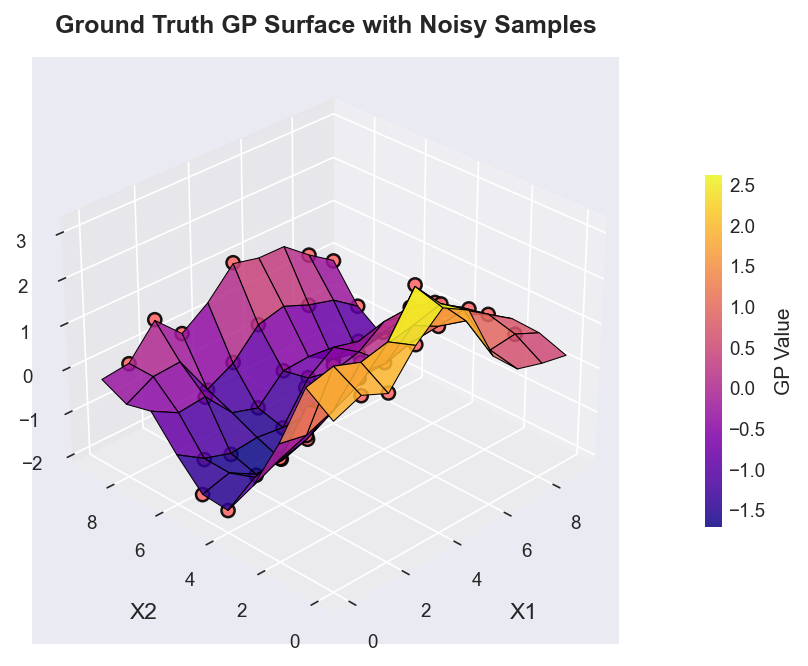

In [35]:
plot_gp_with_subsamples(posterior_mean, mesh_size, train_idx, Y_noisy[train_idx],
                        title='Ground Truth GP Surface with Noisy Samples', cmap='plasma')